In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np

In [2]:
class ConvVAE(nn.Module):
    def __init__(self, latent_dim=20):
        super().__init__()
        # Encoder
        self.conv1 = nn.Conv2d(1, 16, 4, stride=2, padding=1)  # 28x28 -> 14x14
        self.conv2 = nn.Conv2d(16, 32, 4, stride=2, padding=1) # 14x14 -> 7x7
        self.fc_mu = nn.Linear(32 * 7 * 7, latent_dim)
        self.fc_logvar = nn.Linear(32 * 7 * 7, latent_dim)
        # Decoder
        self.fc = nn.Linear(latent_dim, 32 * 7 * 7)
        self.deconv1 = nn.ConvTranspose2d(32, 16, 4, stride=2, padding=1)  # 7x7 -> 14x14
        self.deconv2 = nn.ConvTranspose2d(16, 2, 4, stride=2, padding=1)   # 14x14 -> 28x28

    def encode(self, x):
        h = F.relu(self.conv1(x))
        h = F.relu(self.conv2(h))
        h = h.view(h.size(0), -1)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.fc(z))
        h = h.view(-1, 32, 7, 7)
        h = F.relu(self.deconv1(h))
        h = self.deconv2(h)
        mu, logvar = h[:, :1, :, :], h[:, 1:, :, :]  # Split output into mu and logvar
        return mu, logvar

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_mu, recon_logvar = self.decode(z)
        return recon_mu, recon_logvar, mu, logvar

# ===========================
# Gaussian log-likelihood reconstruction loss
# ===========================

def loss_function(recon_mu, recon_logvar, x, mu, logvar):
    # Gaussian likelihood log p(x|z)
    recon_var = torch.exp(recon_logvar)
    log_px_z = -0.5 * (torch.log(2 * torch.pi * recon_var) + ((x - recon_mu)**2) / recon_var)
    log_px_z = log_px_z.sum()  # Sum over all pixels and batch

    # KL divergence term
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return -log_px_z + KLD, -log_px_z, KLD

# Data loading and splitting
transform = transforms.Compose([transforms.ToTensor()])
mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_ds, val_ds = random_split(mnist, [50000, 10000])
test_ds = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

batch_size = 64
dl_train = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
dl_val = DataLoader(val_ds, batch_size=batch_size)
dl_test = DataLoader(test_ds, batch_size=batch_size)

# Initialize model, optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
gaussian = ConvVAE(latent_dim=20).to(device)
optimizer = torch.optim.Adam(gaussian.parameters(), lr=1.1e-3)



In [14]:
num_epochs = 90
train_elbo = []
val_elbo = []
train_KLD = []
val_KLD = []
train_BCE = []
val_BCE = []

for epoch in range(1, num_epochs+1):
    gaussian.train()
    train_loss = 0
    total_rec = 0
    total_kld = 0
    for x, _ in dl_train:
        x = x.to(device)
        optimizer.zero_grad()
        recon_mu, recon_logvar, mu, logvar = gaussian(x)
        loss, rec_term, kld = loss_function(recon_mu, recon_logvar, x, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        total_rec += rec_term.item()
        total_kld += kld.item()
        optimizer.step()
    avg_train_elbo = -train_loss / len(train_ds)
    train_elbo.append(avg_train_elbo)
    train_BCE.append(total_rec / len(train_ds))
    train_KLD.append(total_kld / len(train_ds))

    gaussian.eval()
    val_loss = 0
    total_val_rec = 0
    total_val_kld = 0
    with torch.no_grad():
        for x, _ in dl_val:
            x = x.to(device)
            recon_mu, recon_logvar, mu, logvar = gaussian(x)
            loss, rec_term, kld = loss_function(recon_mu, recon_logvar, x, mu, logvar)
            val_loss += loss.item()
            total_val_rec += rec_term.item()
            total_val_kld += kld.item()
    avg_val_elbo = -val_loss / len(val_ds)
    val_elbo.append(avg_val_elbo)
    val_BCE.append(total_val_rec / len(val_ds))
    val_KLD.append(total_val_kld / len(val_ds))
    print(f"Epoch {epoch:02d}, Train ELBO: {avg_train_elbo:.4f}, Val ELBO: {avg_val_elbo:.4f}")

    if len(val_BCE) >= 15:
        average_last_10_val_BCE = sum(val_BCE[-10:]) / 10
        average_last_15_val_BCE = sum(val_BCE[-15:]) / 15
        if average_last_15_val_BCE - average_last_10_val_BCE < 0:
            print(f"Early stopping at epoch {epoch} due to no improvement in validation BCE.")
            #break

# Plotting ELBO curves
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.plot(range(1, num_epochs+1), train_elbo, label='Train ELBO')
plt.plot(range(1, num_epochs+1), val_elbo, label='Val ELBO')
plt.xlabel('Epoch')
plt.ylabel('ELBO')
plt.legend()
plt.title('ELBO')

plt.subplot(1, 3, 2)
plt.plot(range(1, num_epochs+1), train_BCE, label='Train log p(x|z)')
plt.plot(range(1, num_epochs+1), val_BCE, label='Val log p(x|z)')
plt.xlabel('Epoch')
plt.ylabel('Log Likelihood')
plt.legend()
plt.title('Reconstruction Term')

plt.subplot(1, 3, 3)
plt.plot(range(1, num_epochs+1), train_KLD, label='Train KLD')
plt.plot(range(1, num_epochs+1), val_KLD, label='Val KLD')
plt.xlabel('Epoch')
plt.ylabel('KL Divergence')
plt.legend()
plt.title('KL Divergence')

plt.tight_layout()
plt.show()

Epoch 01, Train ELBO: 364.3128, Val ELBO: 609.4578


KeyboardInterrupt: 

In [11]:
gaussian_metrics = {
    'train_elbo': train_elbo,
    'val_elbo': val_elbo,
    'train_logpxz': train_BCE,
    'val_logpxz': val_BCE,
    'train_KLD': train_KLD,
    'val_KLD': val_KLD
}

In [5]:
#save the model to file
torch.save(gaussian.state_dict(), 'conv_vae_mnist.pth')

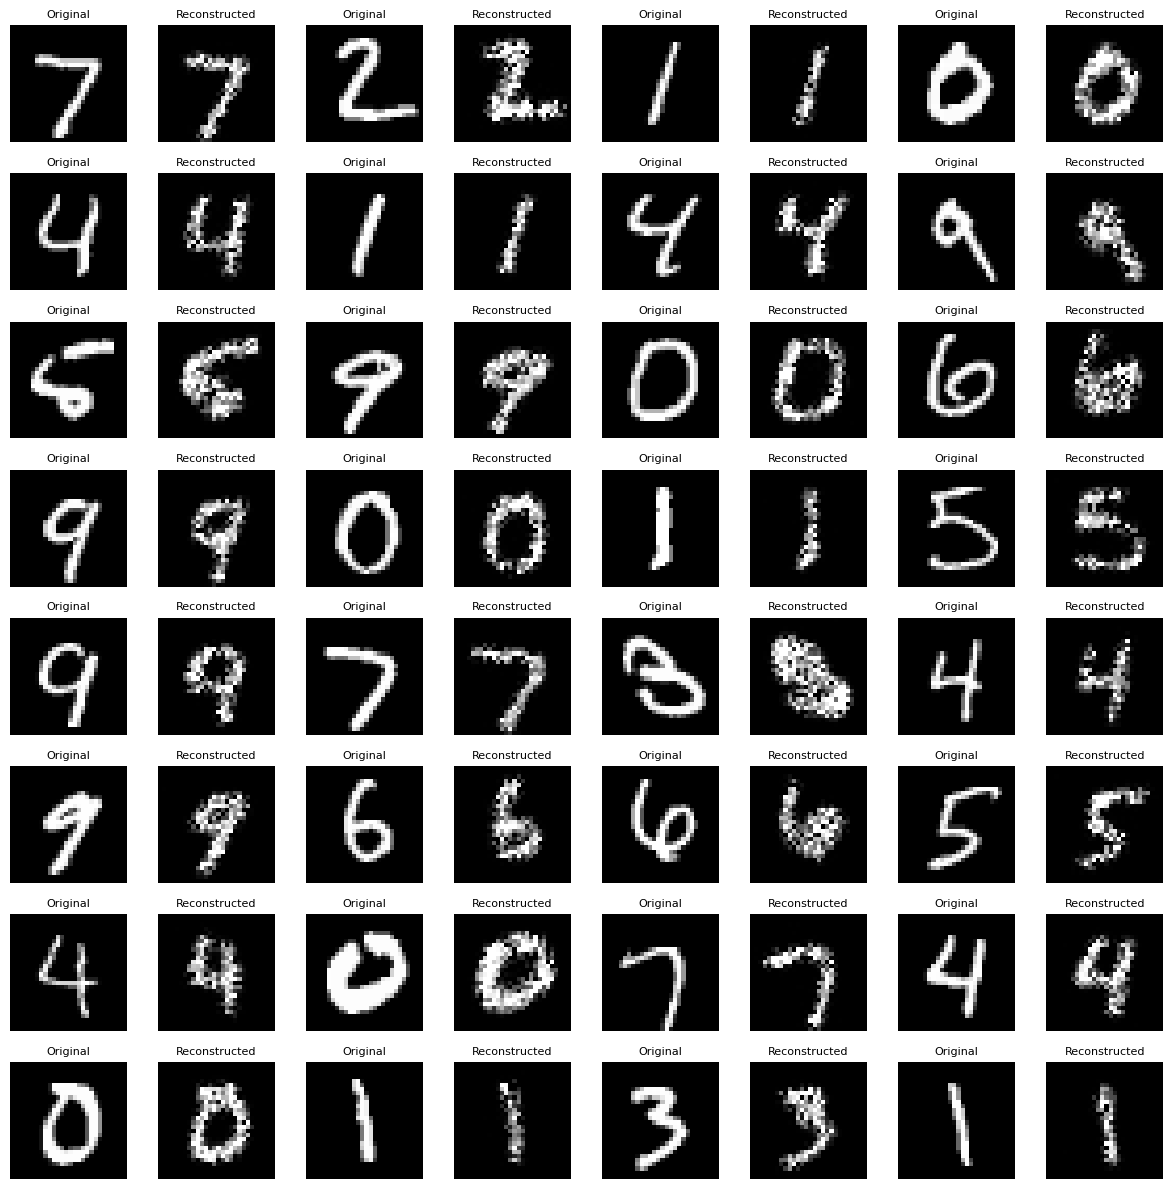

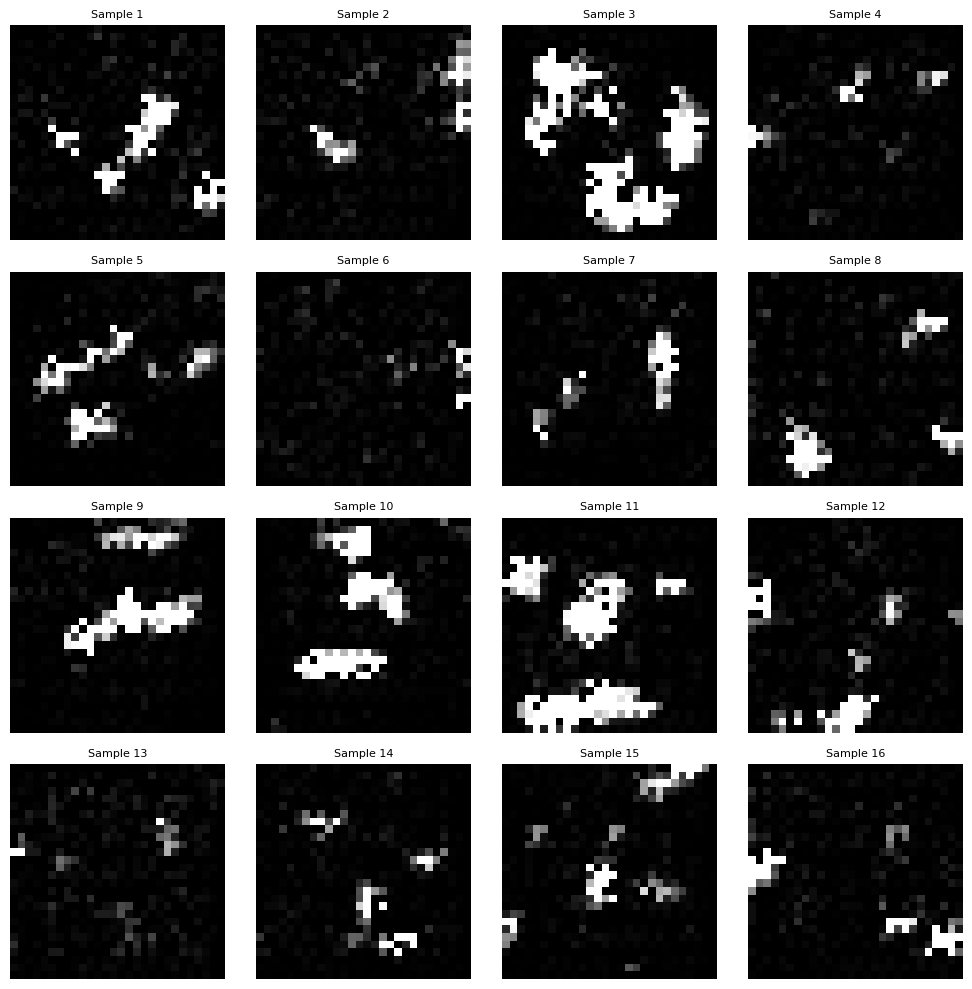

In [3]:
#load the model from file
device = torch.device('cpu')  # Force CPU if no GPU is available

# Safely load the state dict
state_dict = torch.load('./conv_vae_mnist.pth', map_location=device)

# Create model and load weights
gaussian = ConvVAE(latent_dim=20)
gaussian.load_state_dict(state_dict)
gaussian.to(device)

# Reconstructions
gaussian.eval()
with torch.no_grad():
    # Get first 32 test images
    test_batch = next(iter(dl_test))
    test_batch = test_batch[0][:32].to(device)  # Take first 32 images and move to device
    
    # Get reconstructions
    mu, logvar = gaussian.encode(test_batch)
    z = gaussian.reparameterize(mu, logvar)
    recon_mu, recon_logvar = gaussian.decode(z)
    reconstructions = recon_mu + torch.exp(0.5*recon_logvar) * torch.randn_like(recon_mu)
    # Clip reconstructions to [0, 1] range
    reconstructions = torch.clamp(reconstructions, 0, 1)
    
    # Create grid: [orig1, recon1, orig2, recon2, ...]
    grid_images = []
    for i in range(32):
        grid_images.append(test_batch[i].cpu())
        grid_images.append(reconstructions[i].cpu())
    
    # Plot 8×8 grid
    fig, axes = plt.subplots(8, 8, figsize=(12, 12))
    for i, ax in enumerate(axes.flat):
        ax.imshow(grid_images[i].squeeze().cpu().detach().numpy(), cmap='gray')
        ax.axis('off')
        # Label columns
        if i % 2 == 0:
            ax.set_title("Original", fontsize=8)
        else:
            ax.set_title("Reconstructed", fontsize=8)
    plt.tight_layout()
    plt.savefig('reconstructions.png', dpi=150)
    plt.show()



# Sample from prior
z = torch.randn(16, 20).to(device)  # 64 samples
recon_mu, recon_logvar = gaussian.decode(z)
generated = recon_mu + torch.exp(0.5*recon_logvar) * torch.randn_like(recon_mu)
# Clip generated images to [0, 1] range
generated = torch.clamp(generated, 0, 1)

# Plot 8×8 grid
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(generated[i].cpu().detach().squeeze().numpy(), cmap='gray')
    ax.axis('off')
    ax.set_title(f"Sample {i+1}", fontsize=8)
plt.tight_layout()
plt.savefig('generations.png', dpi=150)
plt.show()


# Task 2

In [21]:
class ConvVAE_Beta(nn.Module):
    def __init__(self, latent_dim=20):
        super().__init__()
        # Encoder
        self.conv1 = nn.Conv2d(1, 16, 4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 4, stride=2, padding=1)
        self.fc_mu = nn.Linear(32 * 7 * 7, latent_dim)
        self.fc_logvar = nn.Linear(32 * 7 * 7, latent_dim)

        # Decoder
        self.fc = nn.Linear(latent_dim, 32 * 7 * 7)
        self.deconv1 = nn.ConvTranspose2d(32, 16, 4, stride=2, padding=1)
        self.deconv2 = nn.ConvTranspose2d(16, 2, 4, stride=2, padding=1)  # 2 channels: alpha, beta

    def encode(self, x):
        h = F.relu(self.conv1(x))
        h = F.relu(self.conv2(h))
        h = h.view(h.size(0), -1)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.fc(z))
        h = h.view(-1, 32, 7, 7)
        h = F.relu(self.deconv1(h))
        h = self.deconv2(h)
        alpha_raw, beta_raw = h[:, :1, :, :], h[:, 1:, :, :]  # split channels
        eps = 1e-6
        alpha = F.softplus(alpha_raw) + eps
        beta = F.softplus(beta_raw) + eps
        return alpha, beta

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        alpha, beta = self.decode(z)
        return alpha, beta, mu, logvar


In [22]:
def beta_log_likelihood(x, alpha, beta, eps=1e-6):
    x = torch.clamp(x, eps, 1 - eps)  # ensure numerical stability
    term1 = torch.lgamma(alpha + beta) - torch.lgamma(alpha) - torch.lgamma(beta)
    term2 = (alpha - 1) * torch.log(x)
    term3 = (beta - 1) * torch.log(1 - x)
    return term1 + term2 + term3  # log p(x|z) per pixel

def loss_function_beta(alpha, beta, x, mu, logvar):
    log_px_z = beta_log_likelihood(x, alpha, beta)
    log_px_z = log_px_z.sum()  # sum over all pixels and batch

    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return -log_px_z + KLD, -log_px_z, KLD


Epoch 01, Train ELBO: 6400.2178, Val ELBO: 6619.5714
Epoch 02, Train ELBO: 6701.8731, Val ELBO: 6749.3988
Epoch 03, Train ELBO: 6794.4445, Val ELBO: 6819.7901
Epoch 04, Train ELBO: 6850.9486, Val ELBO: 6863.0787
Epoch 05, Train ELBO: 6896.9369, Val ELBO: 6908.2956
Epoch 06, Train ELBO: 6936.7652, Val ELBO: 6950.5097
Epoch 07, Train ELBO: 6973.7033, Val ELBO: 6977.8759
Epoch 08, Train ELBO: 7008.0412, Val ELBO: 7015.6107
Epoch 09, Train ELBO: 7039.2215, Val ELBO: 7037.0800
Epoch 10, Train ELBO: 7066.1480, Val ELBO: 7076.9289
Epoch 11, Train ELBO: 7089.1005, Val ELBO: 7089.6834
Epoch 12, Train ELBO: 7114.7879, Val ELBO: 7093.9255
Epoch 13, Train ELBO: 7132.0889, Val ELBO: 7138.9649
Epoch 14, Train ELBO: 7154.2991, Val ELBO: 7171.8338
Epoch 15, Train ELBO: 7176.0727, Val ELBO: 7168.6205
Epoch 16, Train ELBO: 7194.8176, Val ELBO: 7196.6419
Epoch 17, Train ELBO: 7209.3765, Val ELBO: 7160.0355
Epoch 18, Train ELBO: 7228.3721, Val ELBO: 6644.5168
Epoch 19, Train ELBO: 7234.4508, Val ELBO: 724

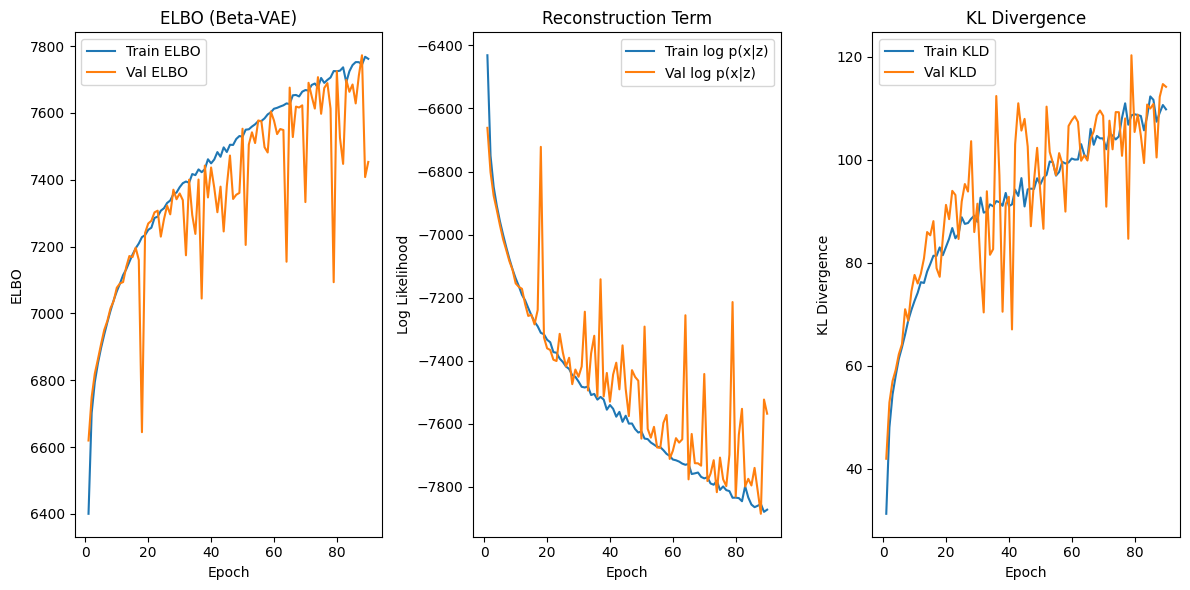

In [10]:

num_epochs = 90
train_elbo_beta = []
val_elbo_beta = []
train_KLD_beta = []
val_KLD_beta = []
train_logpxz_beta = []
val_logpxz_beta = []

model_beta = ConvVAE_Beta(latent_dim=20).to(device)
optimizer = torch.optim.Adam(model_beta.parameters(), lr=1e-3)

# --- Training Loop ---
for epoch in range(1, num_epochs+1):
    model_beta.train()
    train_loss = 0
    total_rec = 0
    total_kld = 0
    for x, _ in dl_train:
        x = x.to(device)
        optimizer.zero_grad()
        alpha, beta_params, mu, logvar = model_beta(x)
        loss, rec_term, kld = loss_function_beta(alpha, beta_params, x, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        total_rec += rec_term.item()
        total_kld += kld.item()
        optimizer.step()

    avg_train_elbo = -train_loss / len(train_ds)
    train_elbo_beta.append(avg_train_elbo)
    train_logpxz_beta.append(total_rec / len(train_ds))
    train_KLD_beta.append(total_kld / len(train_ds))

    model_beta.eval()
    val_loss = 0
    total_val_rec = 0
    total_val_kld = 0
    with torch.no_grad():
        for x, _ in dl_val:
            x = x.to(device)
            alpha, beta_params, mu, logvar = model_beta(x)
            loss, rec_term, kld = loss_function_beta(alpha, beta_params, x, mu, logvar)
            val_loss += loss.item()
            total_val_rec += rec_term.item()
            total_val_kld += kld.item()

    avg_val_elbo = -val_loss / len(val_ds)
    val_elbo_beta.append(avg_val_elbo)
    val_logpxz_beta.append(total_val_rec / len(val_ds))
    val_KLD_beta.append(total_val_kld / len(val_ds))

    print(f"Epoch {epoch:02d}, Train ELBO: {avg_train_elbo:.4f}, Val ELBO: {avg_val_elbo:.4f}")

    if len(val_logpxz_beta) >= 15:
        avg_last_10 = sum(val_logpxz_beta[-10:]) / 10
        avg_last_15 = sum(val_logpxz_beta[-15:]) / 15
        if avg_last_15 - avg_last_10 < 0:
            print(f"Early stopping at epoch {epoch} due to no improvement in validation log p(x|z).")
            # break


# --- Plotting ---
plt.figure(figsize=(12, 6))

# ELBO
plt.subplot(1, 3, 1)
plt.plot(range(1, num_epochs+1), train_elbo_beta, label='Train ELBO')
plt.plot(range(1, num_epochs+1), val_elbo_beta, label='Val ELBO')
plt.xlabel('Epoch')
plt.ylabel('ELBO')
plt.legend()
plt.title('ELBO (Beta-VAE)')

# Log p(x|z)
plt.subplot(1, 3, 2)
plt.plot(range(1, num_epochs+1), train_logpxz_beta, label='Train log p(x|z)')
plt.plot(range(1, num_epochs+1), val_logpxz_beta, label='Val log p(x|z)')
plt.xlabel('Epoch')
plt.ylabel('Log Likelihood')
plt.legend()
plt.title('Reconstruction Term')

# KL Divergence
plt.subplot(1, 3, 3)
plt.plot(range(1, num_epochs+1), train_KLD_beta, label='Train KLD')
plt.plot(range(1, num_epochs+1), val_KLD_beta, label='Val KLD')
plt.xlabel('Epoch')
plt.ylabel('KL Divergence')
plt.legend()
plt.title('KL Divergence')

plt.tight_layout()
plt.show()


In [11]:

results_beta = {
    "train_elbo": train_elbo_beta,
    "val_elbo": val_elbo_beta,
    "train_logpxz": train_logpxz_beta,
    "val_logpxz": val_logpxz_beta,
    "train_KLD": train_KLD_beta,
    "val_KLD": val_KLD_beta,
}


In [12]:
torch.save(model_beta.state_dict(), 'conv_vae_beta.pth')

In [4]:
# Load the Beta-VAE model
model_beta = ConvVAE_Beta(latent_dim=20).to(device)
model_beta.load_state_dict(torch.load('conv_vae_beta.pth'))

# Reconstructions from test data
model_beta.eval()
with torch.no_grad():
    test_batch = next(iter(dl_test))[0][:32].to(device)

    alpha_out, beta_out, _, _ = model_beta(test_batch)
    reconstructions = torch.distributions.Beta(alpha_out, beta_out).sample()
    reconstructions = torch.clamp(reconstructions, 0, 1)

    # Interleave original and reconstructed
    grid_images = []
    for i in range(32):
        grid_images.append(test_batch[i].cpu())
        grid_images.append(reconstructions[i].cpu())

    # Plot 8x8 grid
    fig, axes = plt.subplots(8, 8, figsize=(12, 12))
    for i, ax in enumerate(axes.flat):
        ax.imshow(grid_images[i].squeeze().numpy(), cmap='gray')
        ax.axis('off')
        ax.set_title("Original" if i % 2 == 0 else "Reconstructed", fontsize=8)
    plt.tight_layout()
    plt.savefig('reconstructions_beta.png', dpi=150)
    plt.show()


NameError: name 'ConvVAE_Beta' is not defined

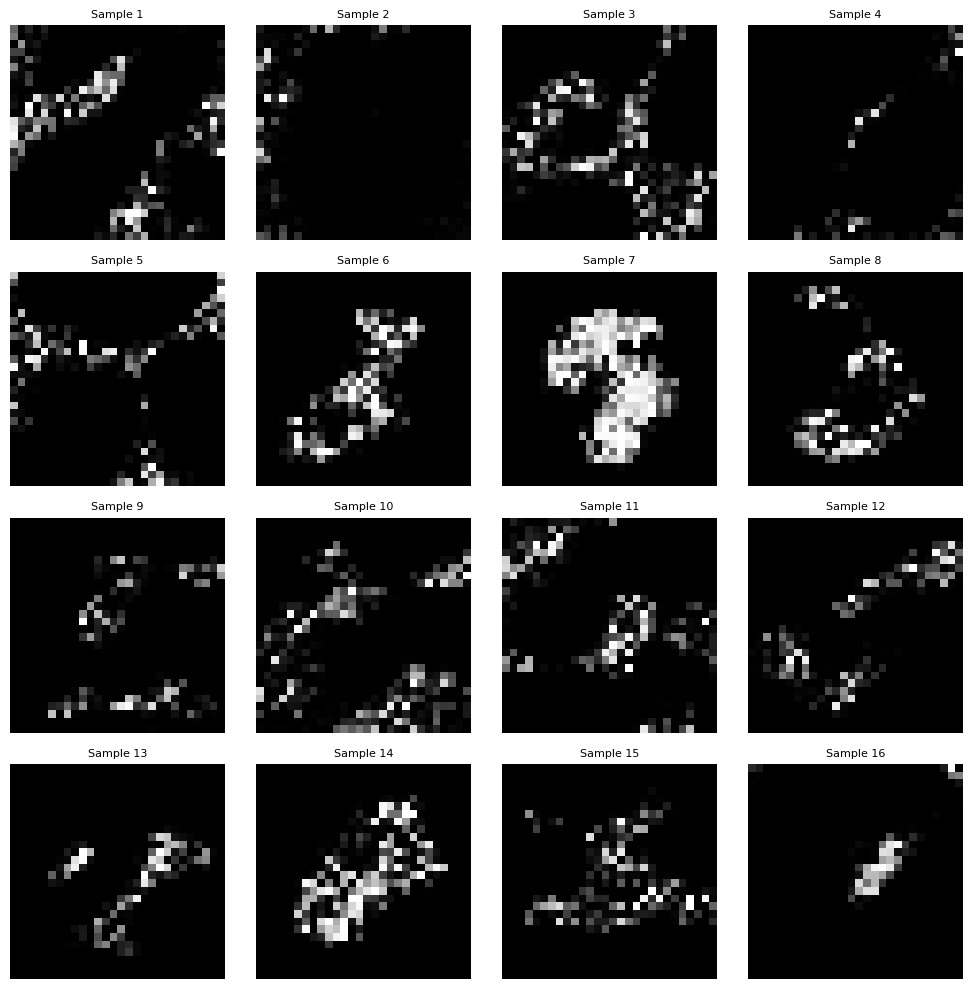

In [14]:
# Sampling from latent space using Beta decoder
z = torch.randn(16, 20).to(device)

# Use the model instance with a distinct name
alpha_out, beta_out = model_beta.decode(z)
generated = torch.distributions.Beta(alpha_out, beta_out).sample()
generated = torch.clamp(generated, 0, 1)

# Plot 4x4 grid of generated samples
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(generated[i].squeeze().cpu().numpy(), cmap='gray')
    ax.axis('off')
    ax.set_title(f"Sample {i+1}", fontsize=8)

plt.tight_layout()
plt.savefig('generations_beta.png', dpi=150)
plt.show()


In [18]:
total_logpxz_gaussian = []
total_logpxz_beta = []

for x, _ in dl_val:
    x = x.to(device)

    # Gaussian decoder
    mu, logvar = gaussian.encode(x)
    z = gaussian.reparameterize(mu, logvar)
    recon_mu, recon_logvar = gaussian.decode(z)
    _, logpxz_gaussian, _ = loss_function(recon_mu, recon_logvar, x, mu, logvar)
    total_logpxz_gaussian.append(logpxz_gaussian.item() / x.shape[0])

    # Beta decoder
    mu, logvar = model_beta.encode(x)
    z = model_beta.reparameterize(mu, logvar)
    alpha_out, beta_out = model_beta.decode(z)
    logpxz_beta = beta_log_likelihood(x, alpha_out, beta_out)
    total_logpxz_beta.append(logpxz_beta.sum().item() / x.shape[0])


print(f"Avg log p(x|z): Gaussian = {np.mean(total_logpxz_gaussian):.2f}, Beta = {np.mean(total_logpxz_beta):.2f}")


Avg log p(x|z): Gaussian = -3124.59, Beta = 7571.47


# Task 3
Task 3 — Investigate the Latent Space [20 points]
For this task, we will investigate the structure of the latent variables Z, and see how
it captures structure that was implicitly present in the data. You may use whichever
model you preferred from Task 1 and Task 2—just be sure to mention your choice in
the report.
Task 3a — Visualizing the Latent Space [5 points] Modify your code so that the la-
tent space is two-dimensional, i.e. such that Z = R2, and train your model to completion
using the appropriate objective function and stopping criterion.
Evaluate the first 1000 datapoints xi, i = 1, . . . , 1000, of the testing data using the
trained encoder network. Visualise the network outputs μ(xi) on a 2-dimensional plot,
color-coding the datapoints based on the class-labels yi, i.e. such that you use a distinct
color for every type of digit. Include this graphic in your report.
Task 3b — Visualizing the Latent Space, using PCA [10 points] Modify your code so
that the latent space is K-dimensional, i.e. such that Z = RK , with K ≥ 10. Train your
model to completion using the appropriate objective function and stopping criterion.
Evaluate the first 1000 datapoints xi, i = 1, . . . , 1000, of the testing data using the
trained encoder network. Store the network outputs μ(xi) in a matrix U with k columns
and 1000 rows.
Perform a Principal Component Analysis on U, and create a 2D scatterplot of the
rows of U projected onto the first two principal components. As in Task 3a, color-code
these datapoints based on the class-labels yi. Include this graphic in your report.
Hint: You do not need to write the code for the PCA yourself; feel free to use whichever
library or python functionality that you prefer.
Task 3c — Interpolation in the Latent Space [5 points] Rather than directly recon-
struct images, one can perform operations on the encoded datapoints by working in the
latent space, and then using the decoder part of the model to translate these operations
to the data-domain.
Make sure you have your favorite variant of the model (Gaussian or Beta) trained to
completion. Now perform the following operations:
1. Take two data points x and x′ from the testing data, making sure that these images
have different class labels y and y′;
2. Obtain samples z and z′ from, respectively, q(Z | x) and q(Z | x′);
3. With λ ∈ [0, 1], compute the linear interpolation zλ = λz + (1 − λ)z′;
4. Obtain a sample xλ from p(X | zλ).
In your report, include a figure containing a grid such that, on each row, the leftmost
entry is x, the rightmost entry is x′, and the k > 1 entries in between are given by xλi ,
with λi on a uniform k-partition of [0, 1].
You are free to choose k and the number of rows of this figure, but please do not
overdo it; make sure that it fits on (at most) a single page of your report.

In [10]:
gaussian = ConvVAE(latent_dim=2).to(device)
optimizer = torch.optim.Adam(gaussian.parameters(), lr=1.1e-3)

In [11]:
num_epochs = 90
train_elbo = []
val_elbo = []
train_KLD = []
val_KLD = []
train_BCE = []
val_BCE = []

for epoch in range(1, num_epochs+1):
    gaussian.train()
    train_loss = 0
    total_rec = 0
    total_kld = 0
    for x, _ in dl_train:
        x = x.to(device)
        optimizer.zero_grad()
        recon_mu, recon_logvar, mu, logvar = gaussian(x)
        loss, rec_term, kld = loss_function(recon_mu, recon_logvar, x, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        total_rec += rec_term.item()
        total_kld += kld.item()
        optimizer.step()
    avg_train_elbo = -train_loss / len(train_ds)
    train_elbo.append(avg_train_elbo)
    train_BCE.append(total_rec / len(train_ds))
    train_KLD.append(total_kld / len(train_ds))

    gaussian.eval()
    val_loss = 0
    total_val_rec = 0
    total_val_kld = 0
    with torch.no_grad():
        for x, _ in dl_val:
            x = x.to(device)
            recon_mu, recon_logvar, mu, logvar = gaussian(x)
            loss, rec_term, kld = loss_function(recon_mu, recon_logvar, x, mu, logvar)
            val_loss += loss.item()
            total_val_rec += rec_term.item()
            total_val_kld += kld.item()
    avg_val_elbo = -val_loss / len(val_ds)
    val_elbo.append(avg_val_elbo)
    val_BCE.append(total_val_rec / len(val_ds))
    val_KLD.append(total_val_kld / len(val_ds))
    print(f"Epoch {epoch:02d}, Train ELBO: {avg_train_elbo:.4f}, Val ELBO: {avg_val_elbo:.4f}")

    if len(val_BCE) >= 15:
        average_last_10_val_BCE = sum(val_BCE[-10:]) / 10
        average_last_15_val_BCE = sum(val_BCE[-15:]) / 15
        if average_last_15_val_BCE - average_last_10_val_BCE < 0:
            print(f"Early stopping at epoch {epoch} due to no improvement in validation BCE.")
            break

Epoch 01, Train ELBO: 418.6252, Val ELBO: 732.4012
Epoch 02, Train ELBO: 596.1308, Val ELBO: 744.4495
Epoch 03, Train ELBO: 789.5242, Val ELBO: 886.2315
Epoch 04, Train ELBO: 864.9353, Val ELBO: 1102.9873
Epoch 05, Train ELBO: 1007.1264, Val ELBO: 1272.0413
Epoch 06, Train ELBO: 1159.2526, Val ELBO: 1378.3337
Epoch 07, Train ELBO: 1174.7618, Val ELBO: 1337.5605
Epoch 08, Train ELBO: 1247.1083, Val ELBO: -790.1039
Epoch 09, Train ELBO: 1298.3842, Val ELBO: 1423.1399
Epoch 10, Train ELBO: 1331.4979, Val ELBO: 1543.9401
Epoch 11, Train ELBO: 1416.8917, Val ELBO: 1637.2985
Epoch 12, Train ELBO: 1400.0014, Val ELBO: 1654.4267
Epoch 13, Train ELBO: 1574.0921, Val ELBO: 1792.1952
Epoch 14, Train ELBO: 1454.8554, Val ELBO: 1739.9472
Epoch 15, Train ELBO: 1470.9756, Val ELBO: 1570.5220
Epoch 16, Train ELBO: 1607.0690, Val ELBO: 1775.4247
Epoch 17, Train ELBO: 1521.2895, Val ELBO: 1772.4148
Epoch 18, Train ELBO: 1601.1883, Val ELBO: 1836.2268
Epoch 19, Train ELBO: 1612.9161, Val ELBO: 420.5454
E

In [12]:
torch.save(gaussian.state_dict(), 'task3_conv_vae_mnist_2d.pth')

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load model with latent_dim=2
gaussian = ConvVAE(latent_dim=2).to(device)
gaussian.load_state_dict(torch.load('task3_conv_vae_mnist_2d.pth', map_location=device))
gaussian.eval()

transform = transforms.Compose([transforms.ToTensor()])
test_ds = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_ds, batch_size=1000, shuffle=False)

x_test, y_test = next(iter(test_loader))
x_test = x_test.to(device)
y_test = y_test.numpy()

In [14]:
with torch.no_grad():
    mu, _ = gaussian.encode(x_test)  # shape (1000, 2)
    mu = mu.cpu().numpy()

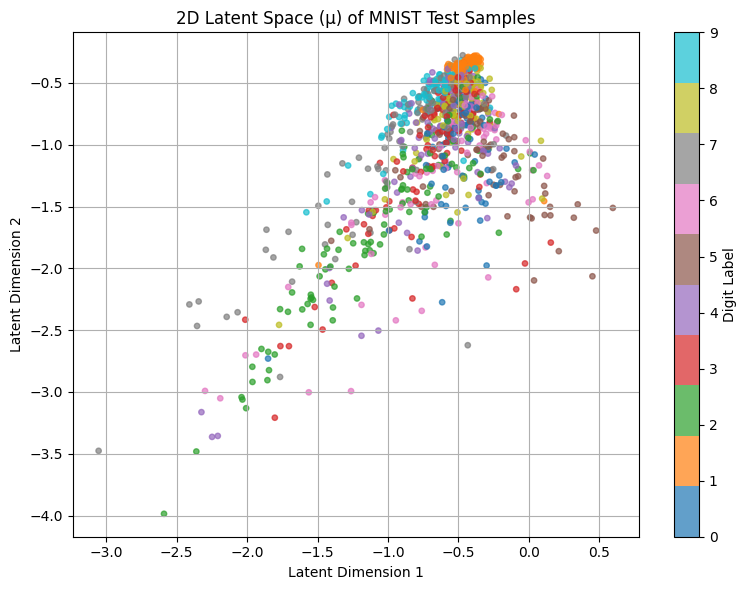

In [15]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(mu[:, 0], mu[:, 1], c=y_test, cmap='tab10', s=15, alpha=0.7)
plt.colorbar(scatter, ticks=range(10), label='Digit Label')
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.title("2D Latent Space (μ) of MNIST Test Samples")
plt.grid(True)
plt.tight_layout()
plt.savefig("task3a_latent_space.png", dpi=150)
plt.show()

### Task 3b

In [16]:
gaussian = ConvVAE(latent_dim=20).to(device)
optimizer = torch.optim.Adam(gaussian.parameters(), lr=1.1e-3)

In [17]:
num_epochs = 90
train_elbo = []
val_elbo = []
train_KLD = []
val_KLD = []
train_BCE = []
val_BCE = []

for epoch in range(1, num_epochs+1):
    gaussian.train()
    train_loss = 0
    total_rec = 0
    total_kld = 0
    for x, _ in dl_train:
        x = x.to(device)
        optimizer.zero_grad()
        recon_mu, recon_logvar, mu, logvar = gaussian(x)
        loss, rec_term, kld = loss_function(recon_mu, recon_logvar, x, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        total_rec += rec_term.item()
        total_kld += kld.item()
        optimizer.step()
    avg_train_elbo = -train_loss / len(train_ds)
    train_elbo.append(avg_train_elbo)
    train_BCE.append(total_rec / len(train_ds))
    train_KLD.append(total_kld / len(train_ds))

    gaussian.eval()
    val_loss = 0
    total_val_rec = 0
    total_val_kld = 0
    with torch.no_grad():
        for x, _ in dl_val:
            x = x.to(device)
            recon_mu, recon_logvar, mu, logvar = gaussian(x)
            loss, rec_term, kld = loss_function(recon_mu, recon_logvar, x, mu, logvar)
            val_loss += loss.item()
            total_val_rec += rec_term.item()
            total_val_kld += kld.item()
    avg_val_elbo = -val_loss / len(val_ds)
    val_elbo.append(avg_val_elbo)
    val_BCE.append(total_val_rec / len(val_ds))
    val_KLD.append(total_val_kld / len(val_ds))
    print(f"Epoch {epoch:02d}, Train ELBO: {avg_train_elbo:.4f}, Val ELBO: {avg_val_elbo:.4f}")

    if len(val_BCE) >= 15:
        average_last_10_val_BCE = sum(val_BCE[-10:]) / 10
        average_last_15_val_BCE = sum(val_BCE[-15:]) / 15
        if average_last_15_val_BCE - average_last_10_val_BCE < 0:
            print(f"Early stopping at epoch {epoch} due to no improvement in validation BCE.")
            break

Epoch 01, Train ELBO: 380.1630, Val ELBO: 155.6654
Epoch 02, Train ELBO: 808.5669, Val ELBO: 839.2938
Epoch 03, Train ELBO: 987.3092, Val ELBO: 1222.7832
Epoch 04, Train ELBO: 1324.7306, Val ELBO: 196.8536
Epoch 05, Train ELBO: 1380.4514, Val ELBO: 1399.6774
Epoch 06, Train ELBO: 1442.6067, Val ELBO: 1101.5967
Epoch 07, Train ELBO: 1316.6676, Val ELBO: 1334.9374
Epoch 08, Train ELBO: 1485.5589, Val ELBO: 1544.8769
Epoch 09, Train ELBO: 1440.0054, Val ELBO: 1699.0321
Epoch 10, Train ELBO: 1702.3232, Val ELBO: 1795.2437
Epoch 11, Train ELBO: 1826.2921, Val ELBO: 2095.8409
Epoch 12, Train ELBO: 1746.8120, Val ELBO: 1906.6648
Epoch 13, Train ELBO: 1932.9467, Val ELBO: 2171.6790
Epoch 14, Train ELBO: 1930.7823, Val ELBO: 1914.8040
Epoch 15, Train ELBO: 1824.8536, Val ELBO: 1779.8146
Epoch 16, Train ELBO: 1915.0965, Val ELBO: 1558.2473
Epoch 17, Train ELBO: 1957.4831, Val ELBO: 2527.6968
Epoch 18, Train ELBO: 2079.3551, Val ELBO: 2152.7423
Epoch 19, Train ELBO: 1847.3136, Val ELBO: 2190.1978

In [18]:
torch.save(gaussian.state_dict(), 'task3b_conv_vae_mnist_20d.pth')

In [19]:
x_test, y_test = next(iter(DataLoader(test_ds, batch_size=1000, shuffle=False)))
x_test = x_test.to(device)
y_test = y_test.numpy()

In [20]:
gaussian.eval()
with torch.no_grad():
    mu, _ = gaussian.encode(x_test)  # shape: [1000, 20]
    U = mu.cpu().numpy()  # Matrix U

In [21]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
U_pca = pca.fit_transform(U)  # shape: [1000, 2]

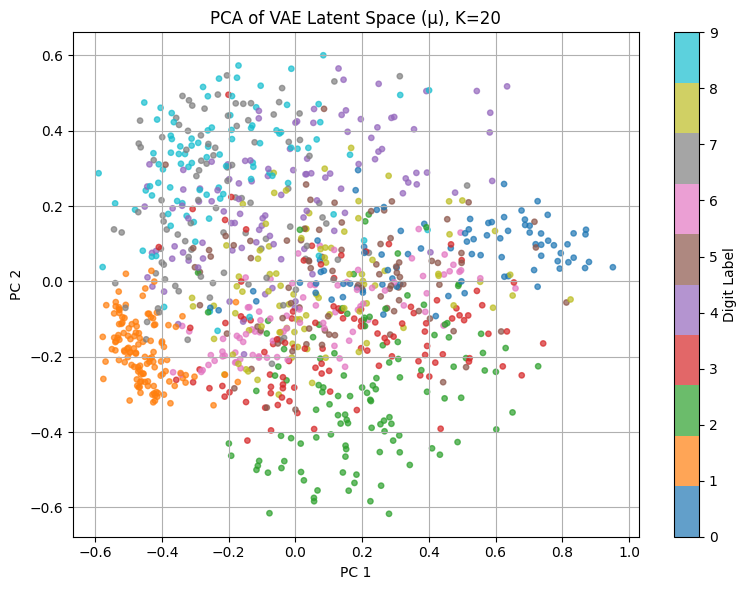

In [22]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(U_pca[:, 0], U_pca[:, 1], c=y_test, cmap='tab10', s=15, alpha=0.7)
plt.colorbar(scatter, ticks=range(10), label='Digit Label')
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.title("PCA of VAE Latent Space (μ), K=20")
plt.grid(True)
plt.tight_layout()
plt.savefig("task3b_latent_pca.png", dpi=150)
plt.show()

### Task 3c

Task 3c — Interpolation in the Latent Space [5 points] Rather than directly recon-
struct images, one can perform operations on the encoded datapoints by working in the
latent space, and then using the decoder part of the model to translate these operations
to the data-domain.
Make sure you have your favorite variant of the model (Gaussian or Beta) trained to
completion. Now perform the following operations:
1. Take two data points x and x′ from the testing data, making sure that these images
have different class labels y and y′;
2. Obtain samples z and z′ from, respectively, q(Z | x) and q(Z | x′);
3. With λ ∈ [0, 1], compute the linear interpolation zλ = λz + (1 − λ)z′;
4. Obtain a sample xλ from p(X | zλ).
In your report, include a figure containing a grid such that, on each row, the leftmost
entry is x, the rightmost entry is x′, and the k > 1 entries in between are given by xλi ,
with λi on a uniform k-partition of [0, 1].
You are free to choose k and the number of rows of this figure, but please do not
overdo it; make sure that it fits on (at most) a single page of your report.

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
gaussian = ConvVAE(latent_dim=20).to(device)
gaussian.load_state_dict(torch.load('conv_vae_mnist.pth', map_location=device))
gaussian.eval()

ConvVAE(
  (conv1): Conv2d(1, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (fc_mu): Linear(in_features=1568, out_features=20, bias=True)
  (fc_logvar): Linear(in_features=1568, out_features=20, bias=True)
  (fc): Linear(in_features=20, out_features=1568, bias=True)
  (deconv1): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv2): ConvTranspose2d(16, 2, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
)

In [ ]:
test_ds = datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor())

# Manually find two images with different labels
x1, y1 = None, None
x2, y2 = None, None
for img, label in test_ds:
    if y1 is None:
        x1, y1 = img, label
    elif label != y1:
        x2, y2 = img, label
        break

print(f"Chosen labels: {y1} and {y2}")

Chosen labels: 7 and 2


In [5]:
x1 = x1.unsqueeze(0).to(device)  # shape (1, 1, 28, 28)
x2 = x2.unsqueeze(0).to(device)

with torch.no_grad():
    mu1, logvar1 = gaussian.encode(x1)
    z1 = gaussian.reparameterize(mu1, logvar1)

    mu2, logvar2 = gaussian.encode(x2)
    z2 = gaussian.reparameterize(mu2, logvar2)

In [ ]:
k = 4  # number of interpolated steps (not counting endpoints)
interpolated_imgs = []

for i in range(k + 2):  # +2 to include endpoints
    λ = i / (k + 1)
    z = λ * z1 + (1 - λ) * z2
    recon_mu, recon_logvar = gaussian.decode(z)
    recon = recon_mu + torch.exp(0.5 * recon_logvar) * torch.randn_like(recon_mu)
    recon = torch.clamp(recon, 0, 1)
    interpolated_imgs.append(recon.squeeze(0).cpu())  # remove batch dim

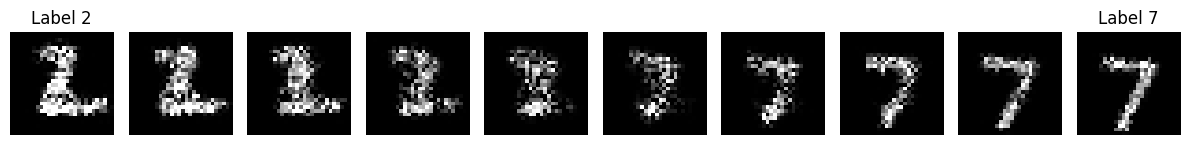

In [7]:
fig, axes = plt.subplots(1, k + 2, figsize=(12, 2))
for i, ax in enumerate(axes):
    ax.imshow(interpolated_imgs[i].squeeze().detach().numpy(), cmap='gray')
    ax.axis('off')
    if i == 0:
        ax.set_title(f"Label {y2}")
    elif i == k + 1:
        ax.set_title(f"Label {y1}")
plt.tight_layout()
plt.savefig("task3c_interpolation2.png", dpi=150)
plt.show()

# Task 4

Task 4 — Inference Without the Encoder [25 points]
For this task, we will attempt to estimate the distribution p(Z | x) without using the
encoder, and see why this is useful. You may use whichever model you preferred from
Task 1 and Task 2—just be sure to mention your choice in the report.
Task 4a — Reconstruction without the Encoder [10 points] Consider a single dat-
apoint x from the testing data. Let q(Z | Ψ) be diagonal Gaussian with independent
components over Z, with parameter vector Ψ – i.e., Ψ contains the mean vector and the
diagonal of the covariance matrix.
Maximise the ELBO for x with respect to Ψ, i.e. compute
Ψ∗ = arg max
Ψ
Eq(Z | Ψ)[log p(x | z)] − KLq(Z | Ψ) || p(Z) ,
using stochastic gradient descent, together with the 1-sample Monte Carlo estimate and
the “reparameterisation trick” to approximately evaluate Eq(Z | Ψ)[log p(x | z)].
After convergence—use and document your choice of stopping criterion—generate a
sample z from q(Z | Ψ∗), and reconstruct x by sampling x′ from p(X | z).
Repeat the above procedure for several different datapoints from the testing data,
making sure to optimise Ψ separately each time. In your report, include a figure con-
taining a 3-column grid where on each row, you display the original datapoint x, the
reconstructed datapoint x′ that you obtained in the manner described above, and a
reconstruction x′′ that you obtained as in Task 1d.
Task 4b — Image Completion [15 points] We will finally use the above techniques to
perform image completion. To this end, consider a single datapoint x from the testing
data, and consider the partition of the variables X into parts XL and XR, representing
respectively the left- and right half of the image. Our goal will be to construct a complete
image x′ given only the left half xL; that is, we want to sample x′
R.
Modify the code that you wrote for Task 4a to instead maximise
Ψ∗ = arg max
Ψ
Eq(Z | Ψ)[log p(xL | z)] − KLq(Z | Ψ) || p(Z) ,
using the same details as before. Note that you can evaluate p(xL | z) by simply evaluat-
ing the model in only the variables of the left half of the image, and ignoring all variables
in the right half (i.e. simply discard the mean and variance for the missing pixels).

Optimizing Ψ for test image 0...
Step 1050: ELBO = -57981.06, Recon Loss = 57959.35, KL = 21.72
Step 1100: ELBO = -79536.46, Recon Loss = 79514.25, KL = 22.21
Step 1150: ELBO = -44963.90, Recon Loss = 44941.76, KL = 22.15
Step 1200: ELBO = -138395.00, Recon Loss = 138371.80, KL = 23.21
Step 1250: ELBO = -113682.94, Recon Loss = 113659.63, KL = 23.31
Step 1300: ELBO = -978312.25, Recon Loss = 978288.94, KL = 23.33
Step 1350: ELBO = -70219.72, Recon Loss = 70196.36, KL = 23.36
Step 1400: ELBO = -40074.24, Recon Loss = 40050.68, KL = 23.56
Step 1450: ELBO = -106635.94, Recon Loss = 106612.03, KL = 23.91
Step 1500: ELBO = -35499.70, Recon Loss = 35475.69, KL = 24.01
Step 1550: ELBO = -36295.08, Recon Loss = 36271.05, KL = 24.03
Step 1600: ELBO = -51635.52, Recon Loss = 51611.39, KL = 24.14
Step 1650: ELBO = -39895.86, Recon Loss = 39871.52, KL = 24.34
Step 1700: ELBO = -32073.14, Recon Loss = 32048.46, KL = 24.68
Step 1750: ELBO = -209836.53, Recon Loss = 209811.73, KL = 24.80
Step 1800: E

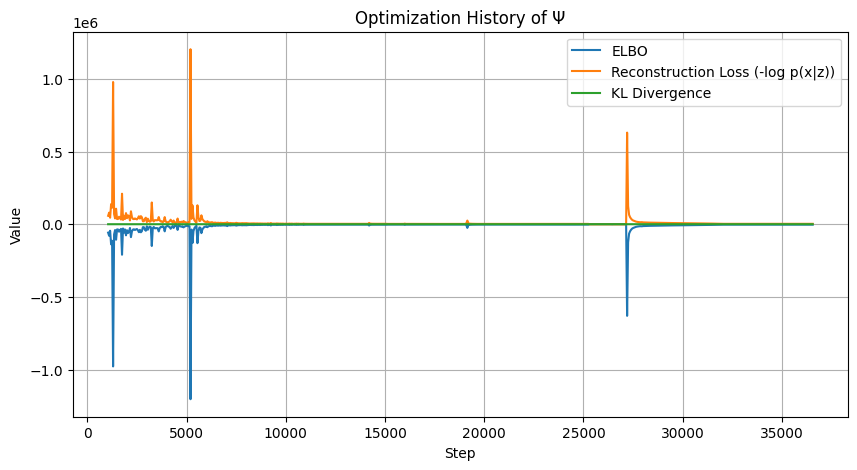

In [32]:
x, _ = test_ds[0]
x = x.unsqueeze(0).to(device)  # Shape: [1, 1, 28, 28]

# Define latent dimension (must match the pre-trained VAE)
latent_dim = 20  # As specified in your original snippet

# 2. OPTIMIZATION of Ψ = {mu_z, logvar_z}

# Initialize Ψ. These are the parameters of q(Z|Ψ) that we will optimize.
# We start from a point near the prior N(0,I).
mu_z = torch.randn(1, latent_dim, device=device, requires_grad=True)
logvar_z = torch.zeros(1, latent_dim, device=device, requires_grad=True)

# Setup optimizer for the parameters Ψ
optimizer = torch.optim.Adam([mu_z, logvar_z], lr=1e-1)

# Lists to store optimization history
history = {'steps': [], 'elbo': [], 'kl': [], 'recon_loss': []}

# Stopping Criterion: Stop if the loss doesn't improve by at least `min_delta`
# for `patience` consecutive checks.
patience = 200
min_delta = 0.01
best_neg_elbo = float('inf')
patience_counter = 0
max_steps = 80000 # Safety break

print(f"Optimizing Ψ for test image {0}...")
for step in range(max_steps):
    optimizer.zero_grad()

    # Apply the reparameterization trick to sample z from q(Z|Ψ)
    std_z = torch.exp(0.5 * logvar_z)
    epsilon = torch.randn_like(std_z)
    z = mu_z + epsilon * std_z

    # Decode z to get the parameters of the distribution p(x|z)
    recon_mu, recon_logvar = gaussian.decode(z)

    # --- Calculate the Negative ELBO (the loss to minimize) ---
    # The ELBO is E[log p(x|z)] - KL(q||p).
    # Minimizing -ELBO is equivalent to minimizing (-E[log p(x|z)]) + KL(q||p).

    # a) Reconstruction Loss: This is -log p(x|z) for a Gaussian likelihood.
    recon_var = torch.exp(recon_logvar)
    recon_loss = F.gaussian_nll_loss(recon_mu, x, recon_var, reduction='sum')

    # b) KL Divergence between q(Z|Ψ) and the prior p(Z) = N(0,I)
    kl_div = -0.5 * torch.sum(1 + logvar_z - mu_z.pow(2) - logvar_z.exp())

    # Total loss to minimize is the negative ELBO
    neg_elbo = recon_loss + kl_div
    neg_elbo.backward()
    optimizer.step()

    # --- Logging and Stopping Criterion ---
    if step % 50 == 0 and step > 1000:
        history['steps'].append(step)
        history['elbo'].append(-neg_elbo.item())
        history['kl'].append(kl_div.item())
        history['recon_loss'].append(recon_loss.item())
        print(f"Step {step:4d}: ELBO = {-neg_elbo.item():.2f}, Recon Loss = {recon_loss.item():.2f}, KL = {kl_div.item():.2f}")

        # Check stopping criterion
        if best_neg_elbo - neg_elbo.item() > min_delta:
            best_neg_elbo = neg_elbo.item()
            patience_counter = 0  # Reset patience
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Stopping early at step {step} as ELBO has not improved significantly.")
            break

# 3. VISUALIZATION

# Plot the optimization history
plt.figure(figsize=(10, 5))
plt.plot(history['steps'], history['elbo'], label='ELBO')
plt.plot(history['steps'], history['recon_loss'], label='Reconstruction Loss (-log p(x|z))')
plt.plot(history['steps'], history['kl'], label='KL Divergence')
plt.title('Optimization History of Ψ')
plt.xlabel('Step')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

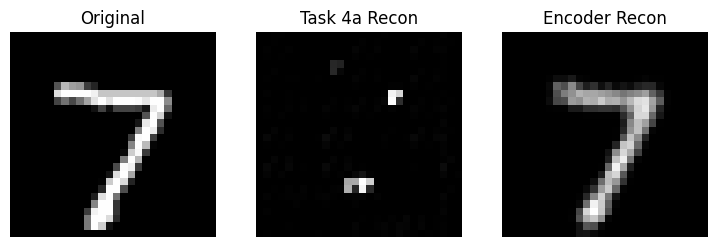

In [34]:
with torch.no_grad():
    # Final z sample
    z_opt = mu_z + torch.exp(0.5 * logvar_z) * torch.randn_like(std)
    recon_mu, _ = gaussian.decode(z_opt)
    #normalise recon_mu to [0, 1] range
    recon_mu = torch.clamp(recon_mu, 0, 1)
    recon_mu = recon_mu.squeeze(0)  # Remove batch dimension


# Reconstruction using encoder (from Task 1)
with torch.no_grad():
    mu_enc, logvar_enc = gaussian.encode(x)
    z_enc = gaussian.reparameterize(mu_enc, logvar_enc)
    recon_enc, _ = gaussian.decode(z_enc)

def show_images(original, recon_ours, recon_enc):
    fig, axs = plt.subplots(1, 3, figsize=(9, 3))
    axs[0].imshow(original.squeeze().cpu(), cmap='gray')
    axs[0].set_title("Original")
    axs[1].imshow(recon_ours.squeeze().cpu(), cmap='gray')
    axs[1].set_title("Task 4a Recon")
    axs[2].imshow(recon_enc.squeeze().cpu(), cmap='gray')
    axs[2].set_title("Encoder Recon")
    for ax in axs:
        ax.axis('off')
    plt.show()

show_images(x, recon_mu, recon_enc)